In [1]:
import numpy as np
import pandas as pd
from numpy.lib.stride_tricks import as_strided
import numbers
from scipy.signal import convolve2d, fftconvolve

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

In [36]:
np.__version__

'1.23.0'

In [37]:
pd.__version__

'1.4.3'

In [2]:
train_df = pd.read_csv('train2022.csv')
test_df = pd.read_csv('test2022.csv')
sub = pd.read_csv('example_submission.csv', index_col='id')

# Общие наблюдения

Из общего вида распределения средних значений в матрице для каждого режима легко предположить, 
как должны выглядеть средние для искомого режима 3:

<AxesSubplot:title={'center':'Режим 3'}>

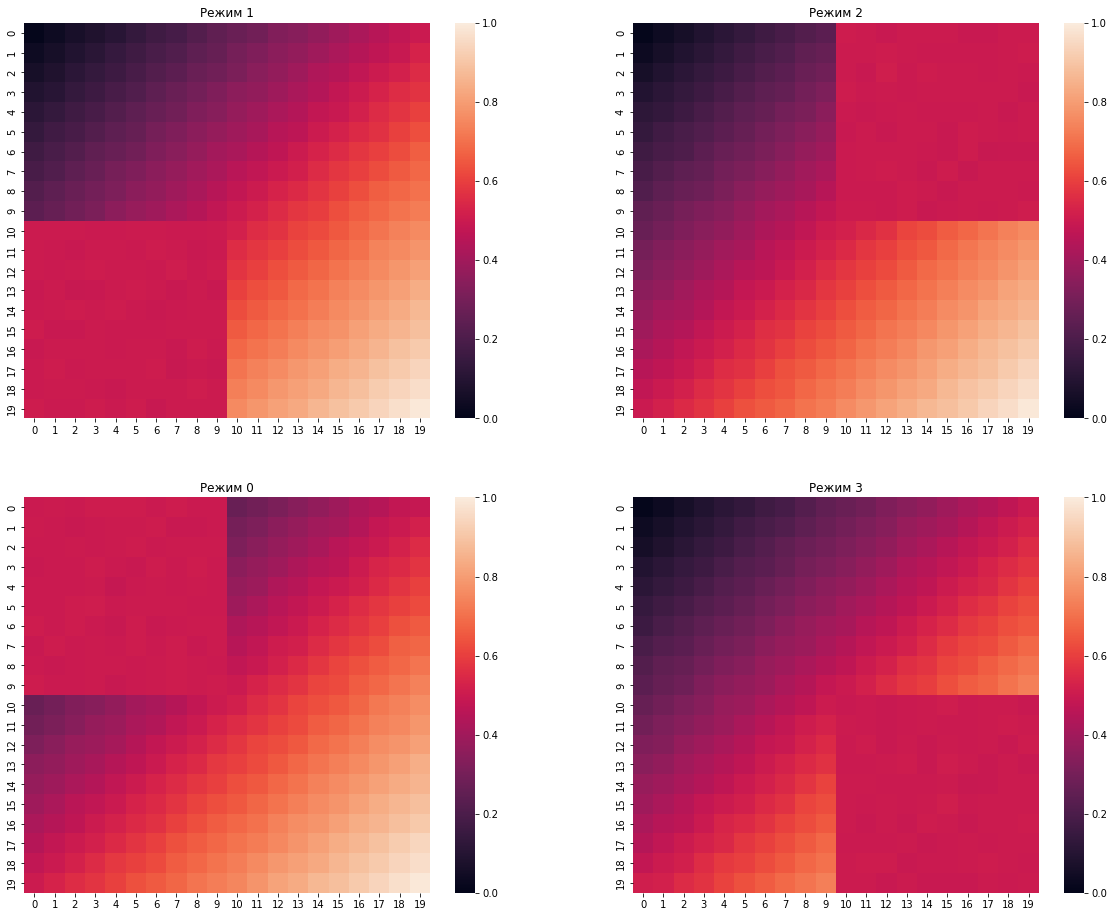

In [3]:
r0 = train_df[train_df.regime==0].iloc[:,403:].mean()
r1 = train_df[train_df.regime==1].iloc[:,403:].mean()
r2 = train_df[train_df.regime==2].iloc[:,403:].mean()
r3 = pd.Series((1 - r0)[::-1].values, index=r0.index)

figure, axes = plt.subplots(2, 2, figsize=(20,16))
axes[0,0].set_title('Режим 1')
axes[0,1].set_title('Режим 2')
axes[1,0].set_title('Режим 0')
axes[1,1].set_title('Режим 3')

sns.heatmap(ax=axes[0,0], data=r1.values.reshape(20,20), vmin=0, vmax=1)
sns.heatmap(ax=axes[0,1], data=r2.values.reshape(20,20), vmin=0, vmax=1)
sns.heatmap(ax=axes[1,0], data=r0.values.reshape(20,20), vmin=0, vmax=1)
sns.heatmap(ax=axes[1,1], data=r3.values.reshape(20,20), vmin=0, vmax=1)

Если внимательно посмотреть на картинки выше и на цифры внутри каждого режима, то можно увидеть, 
что средние значения составлены из диагональных полос с наложением квадрата 10x10, имеющего среднее 0.5 
(в разных углах для разных режимов) с добавлением случайного шума. Итого, 
у нас есть 39 полос в диапазоне от 0.01 до 0.99, отстоящих друг от друга с равным интервалом.
Исходя из этого, можно вычислить средние значения для режима 3 без случайного шума (получается бейзлайн "люблю думать")

In [4]:
d = 0.49/19
r3anal = 400 * [0.01 - d]
for i in range(20):
    r3anal[i*20] = r3anal[(i-1)*20] + d
    for j in range(19):
        r3anal[i*20 + j + 1] = r3anal[i*20 + j] + d
        
ins = 10 * [0.5]
for i in range(10):
    r3anal[210 + i*20 : 220 + i*20] = ins

# Общая идея решения

X - это набор матриц 20х20, которые получаются в результате воздействия функции make_step() 
в течение k шагов на набор матриц Y. Задача в том, чтобы восстановить Y для тестового набора Х. Идея решения:
анализировать для каждого Х из тренировочной выборки все возможные окна 3х3 внутри матриц 20х20 и сопоставлять 
центру каждого окна клетку с соответствующей координатой в Y. Т.к. средние внутри всех диагональных полос одинаковы, 
то будем группировать и усреднять целевые значения Y по полосам (с учетом размещения квадрата 10x10, имеющего среднее 0.5). 
Кроме того, если посмотреть на константные матрицы альфа, бета и гамма из функции make_step(), то станет видно, 
что матрица 20х20 разделена на 9 областей, и для каждой области превращение Y в Х работает по-своему, т.е. группировку
нужно делать с учетом этих областей. Итого, как будет видно из кода далее, получается 115 групп. Число различных 
комбинаций нулей и единиц в окне 3х3 равно 2^9=512. Это общее число паттернов, по которым мы будем искать закономерности.

Таким образом, из тренировочных данных для каждого шага и каждого режима создаем таблички из 512 строк и 115 столбцов, 
где строки соответствуют определенному паттерну из 0 и 1 в окне 3х3 матрицы Х, столбцы - группе координат центров 
этого окна в матрице Y, а значения таблицы - это усредненные значения сгруппированных значений из Y. Далее ищем паттерны 
в тестовой выборке Х и находим им соответствие в полученной табличке со средними значениями.

Тренировочную выборку создадим следующим образом. Разделим Y на 4 квадранта 10х10 для каждого режима (0,1,2), затем будем их 
комбинировать и соединять так, чтобы получить матрицы 20х20, похожие по средним значениям на ожидаемые из режима 3. Этим способом можно создать очень (очень!) много сэмплов, но я остановился на том, что сделал около 400 тысяч.

# Создадим полезные функции

In [5]:
### Разделим поле 20х20 на группы координат (для каждого режима), как описано выше
### Я проверял код на разных режимах, поэтому оставил для общего случая. В решении работает только часть для режима 3.
matrix_split = [np.arange(0,7), np.arange(7,14), np.arange(14,20)]
splits = [[] for a in range(4)] ### Заготовка сплитов для разных режимов 
for ii, split_i in enumerate(matrix_split):
    for jj, split_j in enumerate(matrix_split):
        splits[0].append([[] for v in range(len(split_i)+len(split_j)-1)])
        splits[1].append([[] for v in range(len(split_i)+len(split_j)-1)])
        splits[2].append([[] for v in range(len(split_i)+len(split_j)-1)])
        splits[3].append([[] for v in range(len(split_i)+len(split_j)-1)])
        for i in split_i:
            for j in split_j:
                if i>=10 or j>=10:
                    splits[0][ii*3+jj][i-np.min(split_i)+j-np.min(split_j)].append((i,j))
                if i<10 or j>=10:
                    splits[1][ii*3+jj][i-np.min(split_i)+j-np.min(split_j)].append((i,j))
                if i>=10 or j<10:
                    splits[2][ii*3+jj][i-np.min(split_i)+j-np.min(split_j)].append((i,j))                    
                if i<10 or j<10:
                    splits[3][ii*3+jj][i-np.min(split_i)+j-np.min(split_j)].append((i,j))                    
                    
splits[0].append([[] for u in range(4)])
splits[1].append([[] for u in range(4)])
splits[2].append([[] for u in range(4)])
splits[3].append([[] for u in range(4)])
for i in range(20):
    for j in range(20):
        if i in range(0,7) and j in range(0,7):
            splits[0][9][0].append((i,j))
        if i in range(0,7) and j in range(7,10):
            splits[0][9][1].append((i,j))  
        if i in range(7,10) and j in range(0,7):
            splits[0][9][2].append((i,j))
        if i in range(7,10) and j in range(7,10):
            splits[0][9][3].append((i,j))   
            
        if i in range(10,14) and j in range(0,7):
            splits[1][9][0].append((i,j))
        if i in range(10,14) and j in range(7,10):
            splits[1][9][1].append((i,j))  
        if i in range(14,20) and j in range(0,7):
            splits[1][9][2].append((i,j))
        if i in range(14,20) and j in range(7,10):
            splits[1][9][3].append((i,j))         
            
        if i in range(0,7) and j in range(10,14):
            splits[2][9][0].append((i,j))
        if i in range(0,7) and j in range(14,20):
            splits[2][9][1].append((i,j))  
        if i in range(7,10) and j in range(10,14):
            splits[2][9][2].append((i,j))
        if i in range(7,10) and j in range(14,20):
            splits[2][9][3].append((i,j))                     

        if i in range(10,14) and j in range(10,14):
            splits[3][9][0].append((i,j))
        if i in range(10,14) and j in range(14,20):
            splits[3][9][1].append((i,j))  
        if i in range(14,20) and j in range(10,14):
            splits[3][9][2].append((i,j))
        if i in range(14,20) and j in range(14,20):
            splits[3][9][3].append((i,j)) 

In [6]:
### Проверим, что мы не потеряли ни одной клетки из 400
def get_size_please(x):
    count = 0
    for elem in x:
        if type(elem) == list:
            count += get_size_please(elem)
        else:
            count += 1
    return count
print(get_size_please(splits[3]))

400


In [7]:
### Узнаем, сколько получилось групп
count = 0
for elem in splits[0]:
    if type(elem) == list:
        count += len(elem)
    else:
        count += 1
print(count)

115


In [8]:
### Быстрый векторизованный вариант функции make_step()
def make_step_vect(X):
    n = X.shape[1]
    npad=((0, 0), (1, 1), (1, 1))
    nbrs_count = np.around(fftconvolve(np.pad(X, pad_width=npad, mode='wrap'), np.ones((1,3,3)), mode='valid', axes=(1,2))) - X
    alpha = np.tile(np.floor(np.arange(n) / (n / 3)) + 1, (n, 1))
    beta =  alpha.T + 1
    alpha, beta = np.minimum(alpha, beta), np.maximum(alpha, beta)
    gamma = (alpha + beta) / 2
    return ((nbrs_count <= beta)&(nbrs_count >= gamma)) | (X & (nbrs_count >= alpha)& (nbrs_count <= gamma))

In [9]:
### Функция для выбора окошка 3х3
def select_win(arr_in, window_shape, step=1):

    ndim = arr_in.ndim

    if isinstance(window_shape, numbers.Number):
        window_shape = (window_shape,) * ndim

    if isinstance(step, numbers.Number):
        step = (step,) * ndim

    arr_shape = np.array(arr_in.shape)
    window_shape = np.array(window_shape, dtype=arr_shape.dtype)

    slices = tuple(slice(None, None, st) for st in step)
    window_strides = np.array(arr_in.strides)

    indexing_strides = arr_in[slices].strides

    win_indices_shape = (((np.array(arr_in.shape) - np.array(window_shape))
                          // np.array(step)) + 1)

    new_shape = tuple(list(win_indices_shape) + list(window_shape))
    strides = tuple(list(indexing_strides) + list(window_strides))

    arr_out = as_strided(arr_in, shape=new_shape, strides=strides)
    return arr_out

In [35]:
npad=((0, 0), (1, 1), (1, 1))

### Функция для создания табличек средних значений размером 512х115,
### подсчитывающая mse от предсказания для самого себя
def pred_dense(xnp,ynp,regime):
    dense = np.zeros((512,115))
    ypred = np.empty_like(ynp, dtype='float64')
    Apad = np.pad(xnp, pad_width=npad, mode='wrap')
    out = select_win(Apad,(1,3,3)).reshape(-1,20,20,9)
    znp = out.dot(1 << np.arange(out.shape[-1]))    
    
    for t in tqdm(range(512)):
        h, i, j = np.where(znp==t)
        count = -1
        for group in splits[regime]:
            for split in group:
                count += 1
                masking = np.zeros_like(h, dtype='bool')
                for sp in split:
                    masking += np.isin(i,sp[0]) * np.isin(j,sp[1])
                dense[t, count] = ynp[h[masking],i[masking],j[masking]].mean()
                ypred[h[masking],i[masking],j[masking]] = dense[t, count]
    print(f'Режим {regime}: mse = {mse(ynp.reshape(-1,400), ypred.reshape(-1,400)):.6}')
    return dense

### Функция для создания предсказания для режима 3
def pred_y(dense, x):
    
    xnp = x.to_numpy(dtype='int8').reshape(-1,20,20)
    Apad = np.pad(xnp, pad_width=npad, mode='wrap')
    out = select_win(Apad,(1,3,3)).reshape(-1,20,20,9)
    znp = out.dot(1 << np.arange(out.shape[-1]))    
    ypred = np.empty_like(xnp, dtype='float64')
    
    for t in tqdm(range(512)):
        h, i, j = np.where(znp==t)
        count = -1
        for group in splits[3]:
            for split in group:
                count += 1
                masking = np.zeros_like(h, dtype='bool')
                for sp in split:
                    masking += np.isin(i,sp[0]) * np.isin(j,sp[1])
                if masking.sum() > 0:
                    ypred[h[masking],i[masking],j[masking]] = dense[t, count]
    return ypred

# Работа с данными

Из имеющихся данных для других режимов создадим некую симуляцию Y для режима 3

In [11]:
y0 = train_df[train_df.regime==0].iloc[:,403:].values.reshape(-1,20,20)
y1 = train_df[train_df.regime==1].iloc[:,403:].values.reshape(-1,20,20)
y2 = train_df[train_df.regime==2].iloc[:,403:].values.reshape(-1,20,20)
z0 = 1-np.flip(y0, (1,2)) ### Создание аналога у3 через поворот у0

Распределим подходящие данные по 4 квадрантам

In [12]:
q1 = np.concatenate((y1[:,:10,:10], y2[:,:10,:10], z0[:,:10,:10]), axis=0, dtype='int8')
q2 = np.concatenate((y0[:,:10,10:], y1[:,:10,10:], z0[:,:10,10:]), axis=0, dtype='int8')
q3 = np.concatenate((y0[:,10:,:10], y2[:,10:,:10], z0[:,10:,:10]), axis=0, dtype='int8')
q4 = np.concatenate((y0[:,:10,:10], y1[:,10:,:10], y2[:,:10,10:]), axis=0, dtype='int8')
q2.shape   ### Минимальное число сэмплов

(49895, 10, 10)

Создаем правдоподобный y3, который будет использоваться как таргет в дальнейшем

In [13]:
y_list = []
for a in tqdm(range(2)):
    for b in range(2):
        for c in range(2):
            for d in range(2):
                y_list.append(np.concatenate(
                                    (np.concatenate((q1[a*24947:(a+1)*24947],q3[c*24947:(c+1)*24947]), axis=1),\
                                    np.concatenate((q2[b*24947:(b+1)*24947],q4[d*24947:(d+1)*24947]), axis=1)),\
                                    axis=2))
y3 = np.concatenate(y_list, axis=0)   
y3.shape

  0%|          | 0/2 [00:00<?, ?it/s]

(399152, 20, 20)

Проверяем среднее и стандартное отклонение полученной выборки в сравнении с тем, что должно быть:

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(20,8))
axes[0].set_title('у3.mean()')
axes[1].set_title('ожидаемое для у3.mean()')
sns.heatmap(ax=axes[0], data=y3.mean(axis=0), vmin=0, vmax=1)
sns.heatmap(ax=axes[1], data=r3.values.reshape(20,20), vmin=0, vmax=1)

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(20,8))
axes[0].set_title('у3.std()')
axes[1].set_title('ожидаемое для у3.std()')
sns.heatmap(ax=axes[0], data=y3.std(axis=0), vmin=0, vmax=1)
sns.heatmap(ax=axes[1], data=(1-np.flip(train_df[train_df.regime==0]\
                        .iloc[:,403:].values.reshape(-1,20,20), (1,2))).std(axis=0), \
                vmin=0, vmax=1)

Выделим отдельные части тестовой выборки по шагам

In [16]:
x31 = test_df[test_df.steps==1][[col for col in train_df.columns if col.startswith('x')]]
x32 = test_df[test_df.steps==2][[col for col in train_df.columns if col.startswith('x')]]
x33 = test_df[test_df.steps==3][[col for col in train_df.columns if col.startswith('x')]]
x34 = test_df[test_df.steps==4][[col for col in train_df.columns if col.startswith('x')]]
x35 = test_df[test_df.steps==5][[col for col in train_df.columns if col.startswith('x')]]

Далее делаем предсказания для каждого шага:

# step = 1

In [17]:
%%time
z31 = make_step_vect(y3) 

CPU times: total: 7.69 s
Wall time: 7.69 s


In [18]:
dense31 = pred_dense(z31,y3,3)

  0%|          | 0/512 [00:00<?, ?it/s]

Режим 3: mse = 0.186899


In [19]:
y31pred = pred_y(dense31, x31)

  0%|          | 0/512 [00:00<?, ?it/s]

# step = 2

In [20]:
%%time
z32 = make_step_vect(z31) 

CPU times: total: 7.5 s
Wall time: 7.49 s


In [21]:
dense32 = pred_dense(z32,y3,3)

  0%|          | 0/512 [00:00<?, ?it/s]

Режим 3: mse = 0.217412


In [22]:
y32pred = pred_y(dense32, x32)

  0%|          | 0/512 [00:00<?, ?it/s]

# step = 3

In [23]:
%%time
z33 = make_step_vect(z32) 

CPU times: total: 7.48 s
Wall time: 7.47 s


In [24]:
dense33 = pred_dense(z33,y3,3)

  0%|          | 0/512 [00:00<?, ?it/s]

Режим 3: mse = 0.222442


In [25]:
y33pred = pred_y(dense33, x33)

  0%|          | 0/512 [00:00<?, ?it/s]

# step = 4

In [26]:
%%time
z34 = make_step_vect(z33) 

CPU times: total: 7.5 s
Wall time: 7.5 s


In [27]:
dense34 = pred_dense(z34,y3,3)

  0%|          | 0/512 [00:00<?, ?it/s]

Режим 3: mse = 0.223992


In [28]:
y34pred = pred_y(dense34, x34)

  0%|          | 0/512 [00:00<?, ?it/s]

# step = 5

In [29]:
%%time
z35 = make_step_vect(z34) 

CPU times: total: 7.52 s
Wall time: 7.51 s


In [30]:
dense35 = pred_dense(z35,y3,3)

  0%|          | 0/512 [00:00<?, ?it/s]

Режим 3: mse = 0.224495


In [31]:
y35pred = pred_y(dense35, x35)

  0%|          | 0/512 [00:00<?, ?it/s]

# Делаем предсказание

In [32]:
sub[test_df.steps==1] = y31pred.reshape(-1,400)
sub[test_df.steps==2] = y32pred.reshape(-1,400)
sub[test_df.steps==3] = y33pred.reshape(-1,400)
sub[test_df.steps==4] = y34pred.reshape(-1,400)
sub[test_df.steps==5] = y35pred.reshape(-1,400)
sub = sub.fillna(pd.Series(r3anal, index=sub.columns))
sub.to_csv('sub16.csv')